In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay



pd.set_option('display.max_columns', None)

## Load Data

In [2]:
conversion_data = pd.read_csv('../learn_music_resources/A collection of Data Science take-home challenge/Conversion Rate/conversion_data.csv')

In [3]:
conversion_data

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0
...,...,...,...,...,...,...
316195,US,26,1,Ads,9,0
316196,US,27,1,Direct,6,0
316197,China,25,0,Ads,4,0
316198,US,22,0,Seo,4,0


## Exploratory Data Analysis

In [4]:
conversion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [5]:
conversion_data.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


* It might be a US website and major source are from SEO. 
* The users are pretty young with 75% percentile being 36-year old. Though the max age is 123, which is problematic. Need further inspection.
* New users accounts for 69% -- in the phase of expanding
* Converted rate is 3%, looks reasonable


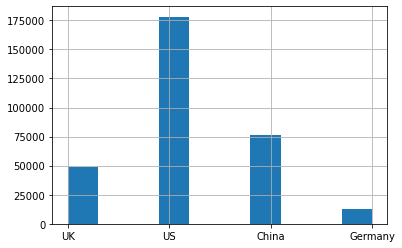

In [6]:
conversion_data['country'].hist()

Likely a US website, with popular audience from China.

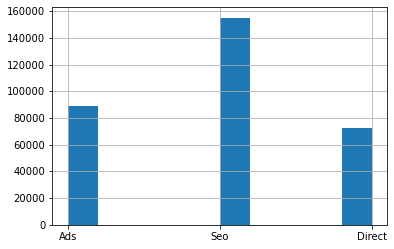

In [7]:
conversion_data['source'].hist()

In [8]:
conversion_data['age'].value_counts().sort_index()

17      7597
18      8466
19      9349
20     10156
21     10966
22     11701
23     12336
24     12960
25     13460
26     13931
27     14084
28     14341
29     14158
30     14346
31     13692
32     13507
33     12631
34     12108
35     11471
36     10779
37      9761
38      8970
39      8202
40      7148
41      6401
42      5588
43      4904
44      4224
45      3634
46      2994
47      2504
48      2121
49      1629
50      1356
51      1093
52       935
53       627
54       520
55       394
56       286
57       247
58       165
59       127
60        94
61        71
62        59
63        35
64        27
65        15
66         9
67         5
68         5
69         3
70         2
72         1
73         1
77         1
79         1
111        1
123        1
Name: age, dtype: int64

Luckily though age with 111 and 123 are only 2 users. We can remove them.

In [9]:
conversion_data = conversion_data[conversion_data['age'] < 100]

In [10]:
conversion_data.groupby('country')['converted'].mean()

country
China      0.001332
Germany    0.062428
UK         0.052612
US         0.037801
Name: converted, dtype: float64

In [11]:
conversion_data.groupby('source')['converted'].mean()

source
Ads       0.034472
Direct    0.028169
Seo       0.032888
Name: converted, dtype: float64

In [12]:
conversion_data.groupby('new_user')['converted'].mean()

new_user
0    0.071983
1    0.014021
Name: converted, dtype: float64

* China has way lower conversion rate than other contries even though has a good number of audience. Conversion rate from Germany, UK, US are inversed with number of audience. 
* Conversion rate from Ads, SEO slightly higher than that from direct.
* As expected, old users has way higher conversion rate than new users.

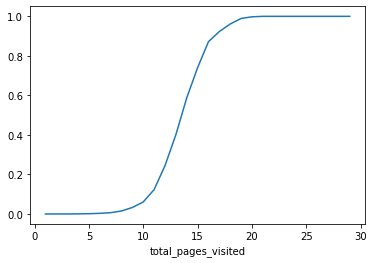

In [13]:
conversion_data.groupby('total_pages_visited')['converted'].mean().plot()

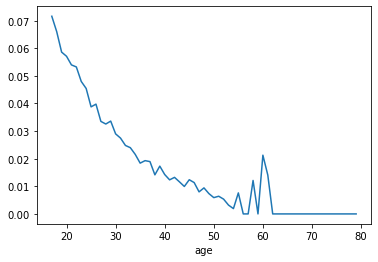

In [14]:
conversion_data.groupby('age')['converted'].mean().plot()

* As expected, more pages viewed, higher conversion rate. And the relationship roughly follows log relationship
* Young users are more likely to convert. It's worthnoting that ther there are spikes of conversion around 60 years old. There are hundreds of users around the age bucket. It worth understanding why they are interested in conversino.

## XGBoost model for conversion rate prediction

In [33]:
# Prepare data
country = pd.get_dummies(conversion_data['country'])
source = pd.get_dummies(conversion_data['source'])

X = pd.concat([conversion_data[['age', 'new_user', 'total_pages_visited']], country, source], axis=1)
features = X.columns
X = np.array(X)
Y = np.array(conversion_data['converted'])

In [34]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

# Cross validation
model = XGBClassifier()
kfold = StratifiedKFold(n_splits=10, random_state = 7)
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/Users/yizezang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Accuracy: 75.66% (1.08%)


In [35]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [41]:
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:, 1]

y_pred_train = model.predict(X_train)
y_score_train = model.predict_proba(X_train)[:, 1]

Precision: 0.8454
Recall: 0.6870
F1: 0.7580
Accuracy: 0.9860


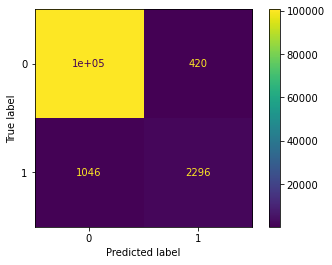

In [37]:
def confusion_matrix_plot(x, y, model):
    y_pred = model.predict(x)
    cm = confusion_matrix(y, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    
confusion_matrix_plot(X_test, y_test, model)
#confusion_matrix_plot(X_train, y_train, model)

In [53]:
train_fpr, train_tpr, _ = roc_curve(y_train, y_score_train, pos_label=model.classes_[1])
test_fpr, test_tpr, _ = roc_curve(y_test, y_score, pos_label=model.classes_[1])
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

test_prec, test_recall, _ = precision_recall_curve(y_test, y_score, pos_label=model.classes_[1])
train_prec, train_recall, _ = precision_recall_curve(y_train, y_score_train, pos_label=model.classes_[1])

Text(0, 0.5, 'Precision')

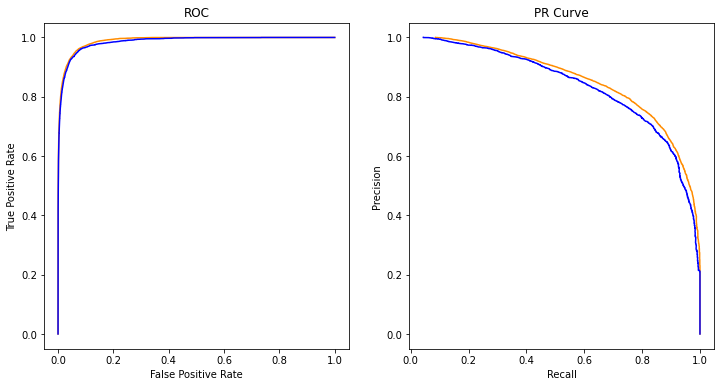

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(train_fpr, train_tpr, color='darkorange')
ax1.plot(test_fpr, test_tpr, color='blue')
ax1.title.set_text('ROC')
ax1.text(0.6, 0.15, f'Test AUC: {test_auc:.4f}')
ax1.text(0.6, 0.1, f'Test Num records: {len(y_test)}')
ax1.text(0.6, 0.05, f'Train AUC: {train_auc:.4f}')
ax1.text(0.6, 0.0, f'Train Num records: {len(y_train)}')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')



ax2.plot(train_prec, train_recall, color='darkorange')
ax2.plot(test_prec, test_recall, color='blue')
ax2.title.set_text('PR Curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

In [39]:
feature_imp = pd.DataFrame()
feature_imp['feature'] = features
feature_imp['importance'] = model.feature_importances_
feature_imp = feature_imp.sort_values(by='importance', ascending=False)
#plt.plot(features, model.feature_importances_)

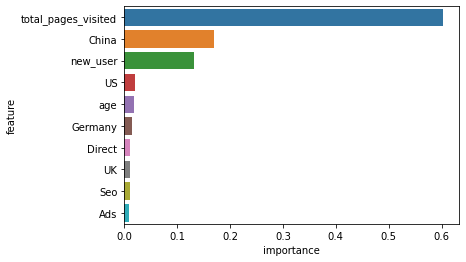

In [40]:
sns.barplot(x="importance", y="feature", data=feature_imp)

Business suggestions:

* China is an important country because even if there are a good number of users, the conversion rate is super low. It's recommended to check if there's problem of the China's version of website, such as if the Chinese version exisits, if the translation works, engineering issue, culture and other issues;
* Old users converts much higher. Target emails to the old users
* 